This notebook will hopefully contain timeseries that plot continuous data from moorings alongside model output. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
saveloc='/ocean/kflanaga/MEOPAR/mooredData'
year=2015
Mooring='Dockton'

In [4]:
##### Loading in pickle file data
with open(os.path.join(saveloc,f'daily_data_{Mooring}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)

In [5]:
%%time
start= dt.datetime(year,1,1)
end=dt.datetime(year,3,1) # the code called below (evaltools.index_model_files) includes the end date 
                          # in the values returned
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
ftype= 'grid_T' # load bio files
tres=24 # 1: hourly resolution; 24: daily resolution   <- try changing to 1 and loading hourly data
flist=et.index_model_files(start,end,basedir,nam_fmt,flen,ftype,tres)
# flist contains paths: file pathes; t_0 timestemp of start of each file; t_n: timestamp of start of next file

#Loading the coordinate data for the different stations
jjii = xr.open_dataset('/ocean/kflanaga/MEOPAR/grid/grid_from_lat_lon_mask999.nc')


CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 102 ms


In [6]:
def get_ij(lat,lon):
    method = 'nearest'
    jj = jjii.jj.sel(lats=lat, lons=lon, method=method).item()
    ii = jjii.ii.sel(lats=lat, lons=lon, method=method).item()
    return ii, jj

In [7]:
data['Lat']

YD
1      47.37611
2      47.37611
3      47.37611
4      47.37611
5      47.37611
         ...   
361    47.37611
362    47.37611
363    47.37611
364    47.37611
365    47.37611
Name: Lat, Length: 365, dtype: float64

In [10]:
# get model i,j of location S3 from places
ii,ij=get_ij(data['Lat'].unique(),data['Lon'].unique())
ik=7 # choose surface level


In [11]:
bio=xr.open_mfdataset(flist['paths'])

In [12]:
bio

<xarray.Dataset>
Dimensions:       (deptht: 40, time_counter: 62, x: 398, y: 898)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2015-01-01T12:00:00 ... 2015-...
    nav_lat       (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
  * deptht        (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
Dimensions without coordinates: x, y
Data variables:
    sossheig      (time_counter, y, x) float32 dask.array<chunksize=(1, 898, 398), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 40, 898, 398), meta=np.ndarray>
Attributes:
    name:         SalishSea_1h_20150101_20150105
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Sep-23 16:40:13 GMT
    uuid:         0d745072-da73-4a21-86d9-7725f51bf5e3

In [15]:
%%time
tt=bio.time_counter
vot=bio.votemper.isel(deptht=ik,y=ij,x=ii)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.14 ms


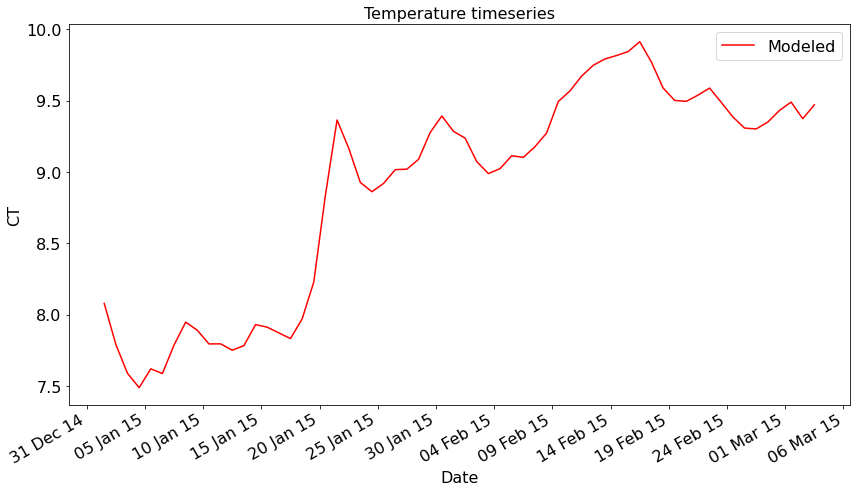

In [17]:
obsvar='CT'
start_date=dt.datetime(year,1,1)
end_date=dt.datetime(year,3,4)
#obs0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date)&(data['SA'] > 10),[obsvar]])
#time0=et._deframe(data.loc[(data['dtUTC'] >= start_date)&(data['dtUTC']<= end_date)&(data['SA'] > 10),['dtUTC']])
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
#p0,=ax.plot(time0,obs0,'-',color='blue',label=f'Observed ')
#ps.append(p0)
p0,=ax.plot(tt,vot,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_xlabel('Date')
ax.set_title('Temperature timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)

In [ ]:
bio.close()

Ok, So time counter instead of time centered works just fine, but how the hell am I going to get the observed data like this? I need to figure out what exactly the model is doing when it plots daily values so I can mimic the exact same thing for the observed. 